<a href="https://colab.research.google.com/github/Bharathi022002/KNOWLEDGE-GRAPH-CREATION-USING-MACHINE-LEARNING/blob/main/KNOWLEDGE_GRAPH_CREATION_USING_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#Knowledge Graph is a set of datapoints linked by relations

#To build a knowledge graph from the text, it is important to make our machine understand natural language.
#This can be done by using NLP techniques such as sentence segmentation, dependency parsing, parts of speech tagging, and entity recognition.

In [ ]:
# Step 1- The first step in building a knowledge graph is to split the text document or article into sentences. 
# Step 2- Extraction of noun and proper noun from sentence can done using parts of speech(POS).when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence. 
# Step 3-To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

In [22]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
#splitting into sentence
candidate_sentences['sentence'].sample(5)

2308    heroes were typically low-ranking officers, not samurai, calmly devoted to his men and his country.
4088                                                                           sara's mom flees to america.
1451                                                                     t. v. chandran and shaji n. karun.
3992                                                                   but i still hoped for a great movie.
2715                                                                               the nfpb adds to the nfr
Name: sentence, dtype: object

In [4]:
#Finding one subject and one object sentence
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... amod
standard ... compound
d823 ... pobj


In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
# Detecting subject and object
get_entities("the film had 200 patents")

['film', '200  patents']

In [7]:
#The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:46<00:00, 92.11it/s] 


In [8]:
#subject object pairs are listed below
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'existing music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel']]

In [9]:
#The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None)

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [10]:
#finding root word or main verb from sentence
get_relation("John completed the task")

'completed'

In [11]:
# Getting the relations from all the Wikipedia sentences:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:39<00:00, 109.42it/s]


In [12]:
#most frequent relations or predicates
pd.Series(relations).value_counts()[:50]

is               364
was              299
released on       88
include           72
are               70
were              65
released          41
's                37
composed by       32
became            31
have              31
has               30
become            28
released in       27
included          23
called            21
produced          21
had               20
made              20
been              20
considered        20
be                18
used              18
scheduled         17
directed by       16
stars             16
received          15
wrote             14
hired             14
produced by       14
written by        13
introduced in     13
went              13
wanted            12
won               11
began             11
set               11
began in          11
includes          10
gave              10
directed          10
sold              10
gives              9
shot in            9
opened             9
cast as            9
known as           9
features     

In [13]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [14]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

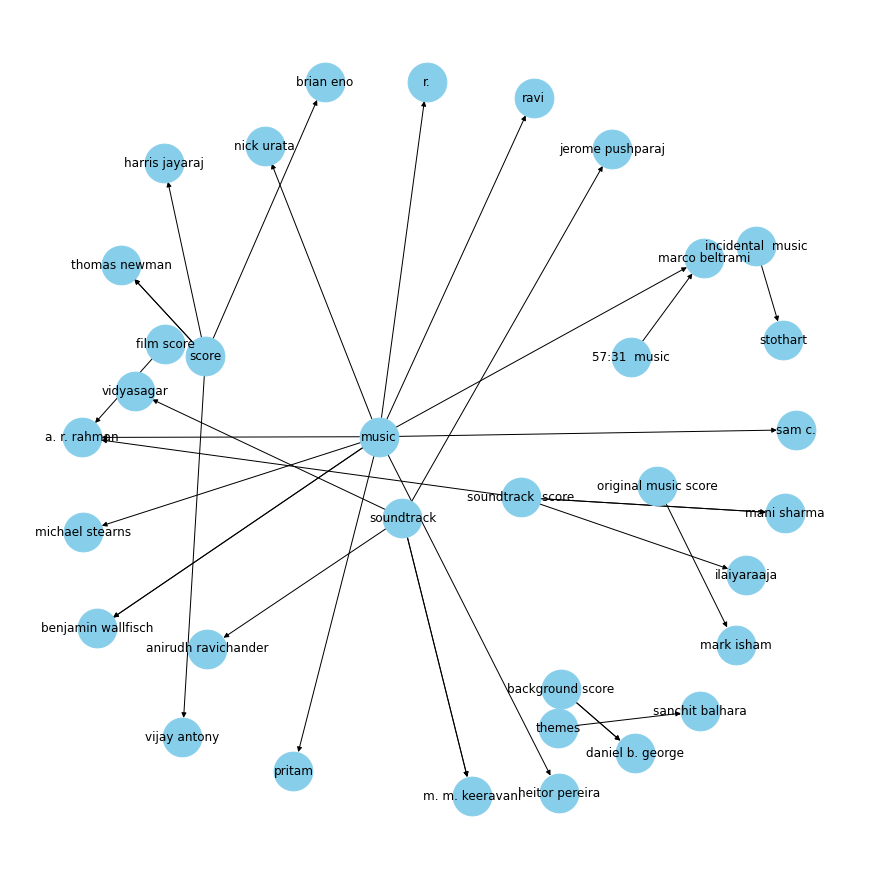

In [18]:
# few important relations 
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

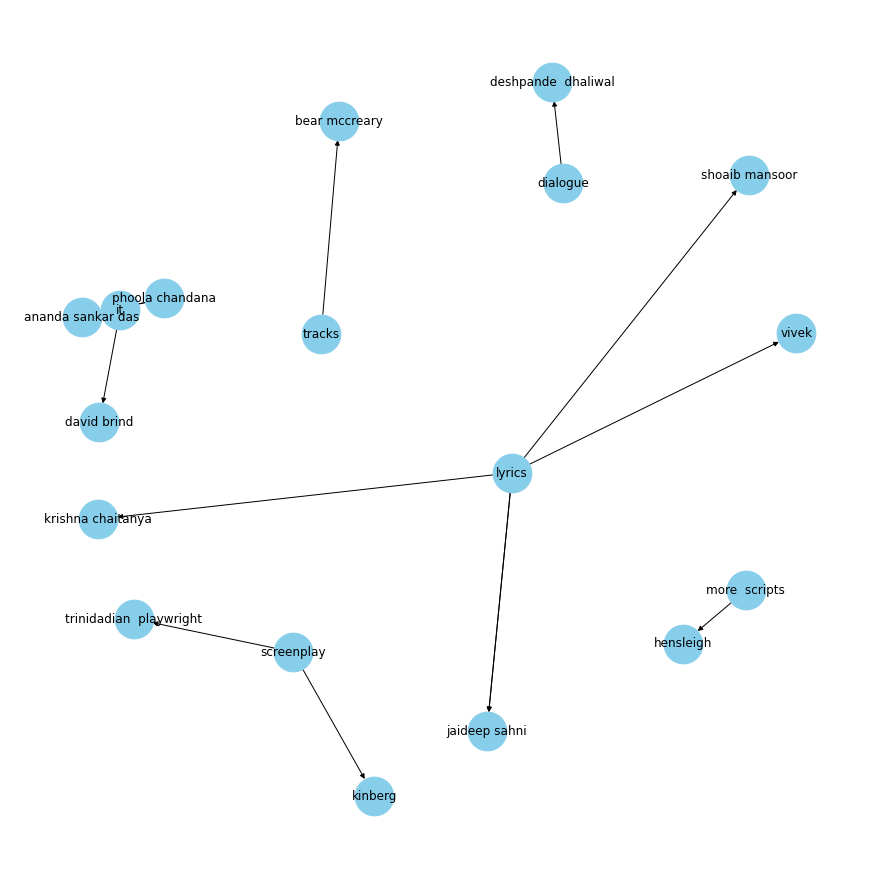

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

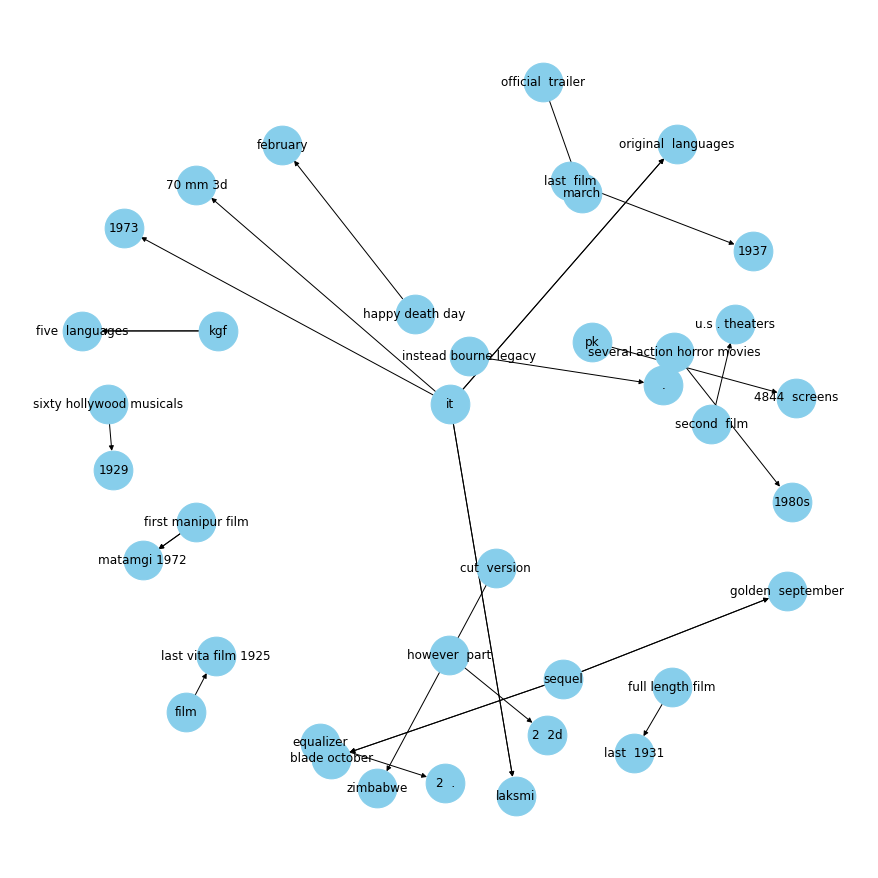

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()